### Loading data

In [33]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
# import geopandas as gpd
import json

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import networkx as nx
from cdlib import algorithms, evaluation


# Consistent theme
import plotly.io as pio
pio.templates.default = "plotly_white"

In [2]:
filename = "../data/thesis/cll_broad_2022_clinical_data_thesis.csv"
df = pd.read_csv(filename)
df.head()

,patientId,sampleId,CLL_EPITYPE,DISEASE_TYPE,IGLV3_21_R110,MUTATION_COUNT,TMB_NONSYNONYMOUS,TUMOR_MOLECULAR_SUBTYPE,U1_STATUS,AGE,...,OS_MONTHS,OS_STATUS,PRIOR_TREATMENT_CATEGORY,SEX,TREATMENT_AFTER_SAMPLING,TREATMENT_STATUS,originId,year,originType,originIdentifier
0,P-CRC-0001,CRC-0001,n-CLL,CLL,No,26.0,0.866667,U-CLL,WT,44.0,...,147.19,1:DECEASED,Untreated,Female,Chemo + Ab,Pre-treatment,2,2019,PUBLICATION,PMID:31142838
1,P-CRC-0002,CRC-0002,n-CLL,CLL,No,23.0,0.766667,U-CLL,WT,55.0,...,154.49,1:DECEASED,Untreated,Male,Chemo + Ab,Pre-treatment,2,2019,PUBLICATION,PMID:31142838
2,P-CRC-0003,CRC-0003,n-CLL,CLL,No,7.0,0.233333,U-CLL,WT,63.0,...,51.25,1:DECEASED,Untreated,Female,Chemo + Ab,Pre-treatment,2,2019,PUBLICATION,PMID:31142838
3,P-CRC-0004,CRC-0004,m-CLL,CLL,No,30.0,1.000000,M-CLL,WT,51.0,...,183.55,0:LIVING,Untreated,Male,Chemo + Ab,Pre-treatment,2,2019,PUBLICATION,PMID:31142838
4,P-CRC-0005,CRC-0005,n-CLL,CLL,No,23.0,0.766667,U-CLL,WT,36.0,...,164.35,0:LIVING,Untreated,Male,Chemo + Ab,Pre-treatment,2,2019,PUBLICATION,PMID:31142838


In [3]:
filename = "../data/thesis/cll_broad_2022_mutations_thesis.csv"
mut_df = pd.read_csv(filename)
mut_df.head()

,chr,endPosition,entrezGeneId,keyword,mutationType,normalAltCount,normalRefCount,patientId,proteinChange,proteinPosEnd,proteinPosStart,referenceAllele,startPosition,tumorAltCount,tumorRefCount,variantAllele,variantType,hugoGeneSymbol,type
0,2,98928394,200403,VWA3B A1212 missense,Missense_Mutation,0.0,12.0,P-CRC-0001,A1212T,1212,1212,G,98928394,3,18,A,SNP,VWA3B,protein-coding
1,2,198267491,23451,SF3B1 E622 missense,Missense_Mutation,3.0,56.0,P-CRC-0001,E622D,622,622,C,198267491,35,27,G,SNP,SF3B1,protein-coding
2,23,83128311,1538,CYLC1 D199 missense,Missense_Mutation,1.0,54.0,P-CRC-0001,D199H,199,199,G,83128311,4,42,C,SNP,CYLC1,protein-coding
3,12,15654580,5800,PTPRO V230 missense,Missense_Mutation,6.0,48.0,P-CRC-0001,V230I,230,230,G,15654580,38,35,A,SNP,PTPRO,protein-coding
4,8,139164553,51059,FAM135B A722 missense,Missense_Mutation,0.0,43.0,P-CRC-0001,A722V,722,722,G,139164553,3,49,A,SNP,FAM135B,protein-coding


In [4]:
df.columns

Index(['patientId', 'sampleId', 'CLL_EPITYPE', 'DISEASE_TYPE', 'IGLV3_21_R110',
       'MUTATION_COUNT', 'TMB_NONSYNONYMOUS', 'TUMOR_MOLECULAR_SUBTYPE',
       'U1_STATUS', 'AGE', 'AGE_SAMPLING', 'COHORT', 'DEATH_DAYS',
       'EXPRESSION_CLUSTER', 'FFS_MONTHS', 'FFS_STATUS',
       'IGHV_IDENTITY_PERCENTAGE', 'IGHV_MUTATION_STATUS', 'OS_MONTHS',
       'OS_STATUS', 'PRIOR_TREATMENT_CATEGORY', 'SEX',
       'TREATMENT_AFTER_SAMPLING', 'TREATMENT_STATUS', 'originId', 'year',
       'originType', 'originIdentifier'],
      dtype='object')

In [5]:
mut_df.columns

Index(['chr', 'endPosition', 'entrezGeneId', 'keyword', 'mutationType',
       'normalAltCount', 'normalRefCount', 'patientId', 'proteinChange',
       'proteinPosEnd', 'proteinPosStart', 'referenceAllele', 'startPosition',
       'tumorAltCount', 'tumorRefCount', 'variantAllele', 'variantType',
       'hugoGeneSymbol', 'type'],
      dtype='object')

In [7]:
# All columns to convert to triplets (except patientId which is subject)
patient_cols = [col for col in df.columns if col != 'patientId']

# Create triplets for patient metadata
triples = []
for _, row in df.iterrows():
    subj = f"Patient_{row['patientId']}"
    for col in patient_cols:
        val = row[col]
        if pd.notna(val):
            pred = f"has_{col}"
            obj = f"{val}" if isinstance(val, str) else str(val)
            triples.append((subj, pred, obj))

# Create triplets for mutations
mut_cols = [col for col in mut_df.columns if col != 'patientId']
for _, row in mut_df.iterrows():
    subj = f"Patient_{row['patientId']}"
    for col in mut_cols:
        val = row[col]
        if pd.notna(val):
            pred = f"has_{col}"
            obj = f"{val}" if isinstance(val, str) else str(val)
            triples.append((subj, pred, obj))

# Convert to DataFrame
triplet_df = pd.DataFrame(triples, columns=['subject', 'predicate', 'object'])

# OPTIONAL: Add node types for Neo4j categorization (e.g., :Patient, :Gene)
def get_node_type(obj):
    if obj.startswith('Patient_'):
        return 'Patient'
    elif obj in df['SEX'].unique():
        return 'Sex'
    elif obj in df['CLL_EPITYPE'].unique():
        return 'CLL_Epitype'
    elif obj in mut_df['hugoGeneSymbol'].unique():
        return 'Gene'
    elif obj in mut_df['mutationType'].unique():
        return 'MutationType'
    else:
        return 'Attribute'

triplet_df['subject_type'] = triplet_df['subject'].apply(get_node_type)
triplet_df['object_type'] = triplet_df['object'].apply(get_node_type)

# Export for Neo4j
triplet_df.to_csv('../data/thesis/kg_triplets_for_neo4j.csv', index=False)


In [24]:
# upload to Neo4j
# Use the following Cypher query to create nodes and relationships
from neo4j import GraphDatabase

NEO4J_USERNAME = "neo4j"
NEO4J_PASSWORD = "password@123" 
NEO4J_URI = "bolt://localhost:7687"

class Neo4jConnection:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()

    def execute_query(self, query):
        with self.driver.session() as session:
            result = session.run(query)
            return [record for record in result]
        

# Connect to Neo4j

neo4j_conn = Neo4jConnection(NEO4J_URI, NEO4J_USERNAME, NEO4J_PASSWORD)

# upload the triplets to Neo4j
query = """LOAD CSV WITH HEADERS FROM 'file:////Users/mahikajaguste/UL-Code/Dissertation/msc-thesis/data/thesis/kg_triplets_for_neo4j.csv' AS row
MERGE (s:Node {name: row.subject, type: row.subject_type})
MERGE (o:Node {name: row.object, type: row.object_type})
MERGE (s)-[:HAS {predicate: row.predicate}]->(o)"""

neo4j_conn.execute_query(query)


# # Example query to fetch all patients and their attributes
# query = """MATCH (p:Node {type: 'Patient'})-[r:HAS]->(a:Node)
# RETURN p.name AS patient, r.predicate AS attribute, a.name AS value
# ORDER BY p.name, r.predicate"""
# results = neo4j_conn.execute_query(query)
# # Convert results to DataFrame
# neo4j_df = pd.DataFrame(results, columns=['patient', 'attribute', 'value'])
# # Display the DataFrame
# print(neo4j_df.head())

[]

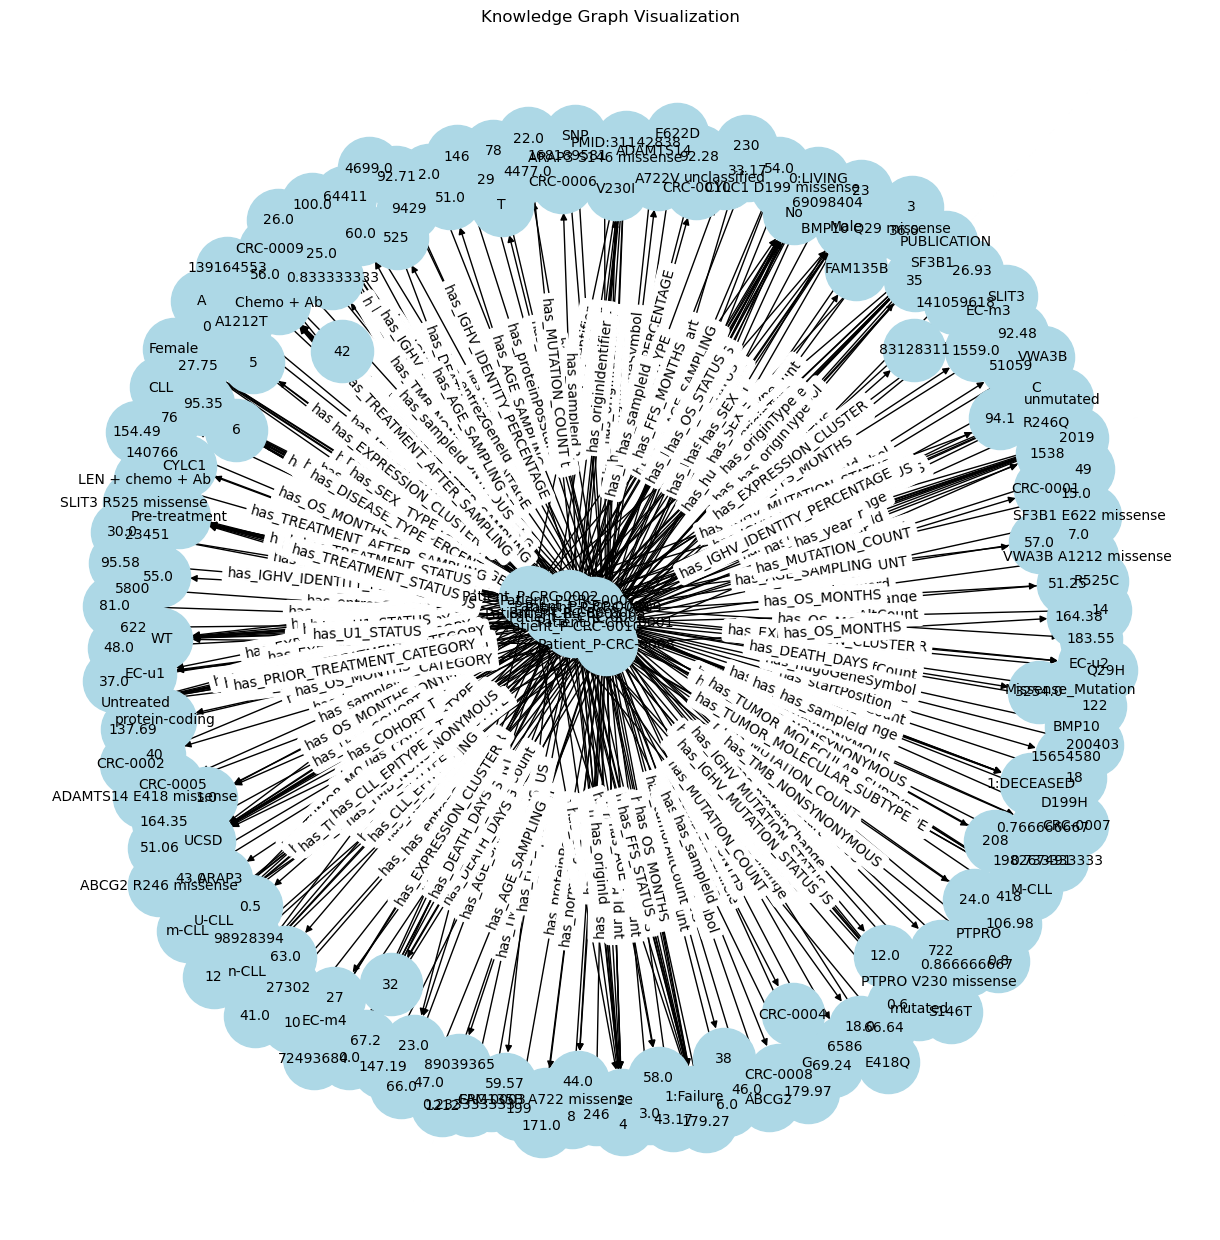

In [25]:
# visualise the graph in python interactively
import networkx as nx
def visualize_graph(triplet_df):
    G = nx.DiGraph()

    # Add nodes and edges
    for _, row in triplet_df.iterrows():
        G.add_node(row['subject'], type=row['subject_type'])
        G.add_node(row['object'], type=row['object_type'])
        G.add_edge(row['subject'], row['object'], predicate=row['predicate'])

    # Draw the graph
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_color='black', arrows=True)
    
    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'predicate')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Knowledge Graph Visualization")
    plt.show()

visualize_graph(triplet_df)

In [31]:
# Perform hierarchical leiden community detection on the graph with integer node mapping
def perform_leiden_community_detection(triplet_df):
    G = nx.DiGraph()

    # Add nodes and edges
    for _, row in triplet_df.iterrows():
        G.add_node(row['subject'], type=row['subject_type'])
        G.add_node(row['object'], type=row['object_type'])
        G.add_edge(row['subject'], row['object'], predicate=row['predicate'])

    # Convert to undirected graph for community detection
    G_undirected = G.to_undirected()

    # Map node names to integers
    node_to_int = {node: idx for idx, node in enumerate(G_undirected.nodes())}
    int_to_node = {idx: node for node, idx in node_to_int.items()}
    G_int = nx.relabel_nodes(G_undirected, node_to_int)

    # Perform Leiden community detection
    communities_int = algorithms.leiden(G_int)

    # Map communities back to original node names
    communities = []
    for community in communities_int.communities:
        communities.append([int_to_node[node] for node in community])

    # Print community information
    print(f"Number of communities detected: {len(communities)}")
    for i, community in enumerate(communities):
        print(f"Community {i+1}: {community}")  
    # Evaluate the quality of the detected communities
    modularity = evaluation.modularity_overlap(G_int, communities_int)
    print(f"Modularity of the detected communities: {modularity}")

    # Return a structure similar to cdlib's output for compatibility
    from types import SimpleNamespace
    return SimpleNamespace(communities=communities)

# Perform community detection
communities = perform_leiden_community_detection(triplet_df)



Number of communities detected: 3
Community 1: ['Patient_P-CRC-0001', 'CRC-0001', '26.0', '0.866666667', '44.0', '46.0', '4477.0', '43.17', '147.19', '1.0', '54.0', '98928394', '200403', 'VWA3B A1212 missense', 'Missense_Mutation', '12.0', 'A1212T', '1212', 'G', '3', '18', 'A', 'SNP', 'VWA3B', 'protein-coding', '198267491', '23451', 'SF3B1 E622 missense', '3.0', 'E622D', '622', 'C', '35', '27', 'SF3B1', '23', '83128311', '1538', 'CYLC1 D199 missense', 'D199H', '199', '4', '42', 'CYLC1', '12', '15654580', '5800', 'PTPRO V230 missense', '6.0', '48.0', 'V230I', '230', '38', 'PTPRO', '8', '139164553', '51059', 'FAM135B A722 missense', '43.0', 'A722V', '722', '49', 'FAM135B', '89039365', '9429', 'ABCG2 R246 missense', '41.0', 'R246Q', '246', '32', '40', 'T', 'ABCG2', '5', '168189581', '6586', 'SLIT3 R525 missense', '81.0', 'R525C', '525', '6', '122', 'SLIT3', '10', '72493684', '140766', 'ADAMTS14 E418 missense', 'E418Q', '418', '76', 'ADAMTS14', '69098404', '27302', 'BMP10 Q29 missense', 'Q

#### NCT Trials

In [9]:
nctIds = df[df['originType'] == 'TRIAL']['originIdentifier'].unique()
print(f"Number of unique NCT IDs: {len(nctIds)}")
print(nctIds)

Number of unique NCT IDs: 0
[]


In [10]:
filename = "../data/clinicaltrialsgov/cll_343_SelectedFields.csv"
df_trials = pd.read_csv(filename)
df_trials = df_trials[df_trials['protocolSection.identificationModule.nctId'].isin(nctIds)]
df_trials.head()

,protocolSection.identificationModule.nctId,protocolSection.identificationModule.officialTitle,protocolSection.identificationModule.acronym,protocolSection.descriptionModule.briefSummary,protocolSection.descriptionModule.detailedDescription,protocolSection.conditionsModule.conditions,protocolSection.conditionsModule.keywords,protocolSection.designModule.studyType,protocolSection.designModule.phases,protocolSection.designModule.designInfo.allocation,...,resultsSection.baselineCharacteristicsModule.denoms,resultsSection.baselineCharacteristicsModule.measures,resultsSection.baselineCharacteristicsModule.populationDescription,resultsSection.outcomeMeasuresModule.outcomeMeasures,resultsSection.adverseEventsModule.frequencyThreshold,resultsSection.adverseEventsModule.timeFrame,resultsSection.adverseEventsModule.description,resultsSection.adverseEventsModule.eventGroups,resultsSection.adverseEventsModule.seriousEvents,resultsSection.adverseEventsModule.otherEvents


In [11]:
filename = "../data/clinicaltrialsgov/ctg-studies.json"
with open(filename, 'r') as f:
    trials = json.load(f)

trials = [trial for trial in trials if trial['protocolSection']['identificationModule']['nctId'] in nctIds]
print(f"Number of trials in JSON: {len(trials)}")
trials

Number of trials in JSON: 0


[]

### Community Detection

In [12]:
# Load data
patient_df = df.copy(deep=True)
mutation_df = mutations_df.copy(deep=True)

# --- Preprocessing Patient Data ---

# Select relevant columns
patient_features = patient_df[['patientId', 'AGE', 'MUTATION_COUNT', 'TMB_NONSYNONYMOUS', 
                               'SEX', 'TREATMENT_STATUS', 'CLL_EPITYPE', 'IGHV_MUTATION_STATUS']].copy()

# Fill missing with mode or mean
patient_features['AGE'].fillna(patient_features['AGE'].mean(), inplace=True)
patient_features['MUTATION_COUNT'].fillna(0, inplace=True)
patient_features['TMB_NONSYNONYMOUS'].fillna(0, inplace=True)
patient_features.fillna('Unknown', inplace=True)

# Normalize numeric columns
scaler = MinMaxScaler()
patient_features[['AGE', 'MUTATION_COUNT', 'TMB_NONSYNONYMOUS']] = scaler.fit_transform(
    patient_features[['AGE', 'MUTATION_COUNT', 'TMB_NONSYNONYMOUS']]
)

# One-hot encode categoricals
categorical_cols = ['SEX', 'TREATMENT_STATUS', 'CLL_EPITYPE', 'IGHV_MUTATION_STATUS']
encoded_df = pd.get_dummies(patient_features[categorical_cols])

# Combine features
features = pd.concat([patient_features[['patientId', 'AGE', 'MUTATION_COUNT', 'TMB_NONSYNONYMOUS']], encoded_df], axis=1)

# --- Mutation Binary Vectors ---

# Filter key genes (or most frequent top N)
top_genes = mutation_df['hugoGeneSymbol'].value_counts().head(10).index
filtered_mutations = mutation_df[mutation_df['hugoGeneSymbol'].isin(top_genes)]

mutation_matrix = filtered_mutations.pivot_table(index='patientId', 
                                                  columns='hugoGeneSymbol', 
                                                  aggfunc='size', 
                                                  fill_value=0)

# Merge features
merged = features.merge(mutation_matrix, how='left', left_on='patientId', right_index=True)
merged.fillna(0, inplace=True)
merged.set_index('patientId', inplace=True)

# --- Similarity Matrix ---

sim_matrix = cosine_similarity(merged)
sim_df = pd.DataFrame(sim_matrix, index=merged.index, columns=merged.index)

# --- Graph Construction ---

G = nx.Graph()
for pid in merged.index:
    G.add_node(pid)

# Create edges with similarity above threshold
threshold = 0.6
for i, pid1 in enumerate(merged.index):
    for j, pid2 in enumerate(merged.index):
        if i < j and sim_df.loc[pid1, pid2] > threshold:
            G.add_edge(pid1, pid2, weight=sim_df.loc[pid1, pid2])

# --- Visualize Graph ---

pos = nx.spring_layout(G, seed=42)
edge_x, edge_y = [], []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(x=edge_x, y=edge_y, mode='lines', line=dict(width=0.5, color='#888'), hoverinfo='none')

node_x, node_y = [], []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y, mode='markers+text',
    text=list(G.nodes()), textposition="top center",
    marker=dict(size=10, color='blue')
)

fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(title='Patient Similarity Graph', showlegend=False,
                                 hovermode='closest', margin=dict(b=20,l=5,r=5,t=40)))
fig.write_html("patient_similarity_graph.html")

NameError: name 'mutations_df' is not defined

In [ ]:
# --- Community Detection ---

# Louvain
louvain_communities = algorithms.louvain(G, weight='weight')
print("Louvain - Number of communities:", len(louvain_communities.communities))


# leiden 
leiden_communities = algorithms.leiden(G, weight='weight')
print("Leiden - Number of communities:", len(leiden_communities.communities))

# Label Propagation
lp_communities = algorithms.label_propagation(G)
print("Label Propagation - Number of communities:", len(lp_communities.communities))

# --- Evaluation: Compare with Epitype Label ---

true_labels = patient_df.set_index('patientId').loc[merged.index]['CLL_EPITYPE']
pred_labels_louvain = [None]*len(merged)
for i, community in enumerate(louvain_communities.communities):
    for node in community:
        idx = list(merged.index).index(node)
        pred_labels_louvain[idx] = i

# Metrics
ari = adjusted_rand_score(true_labels, pred_labels_louvain)
nmi = normalized_mutual_info_score(true_labels, pred_labels_louvain)
print("Louvain ARI:", ari)
print("Louvain NMI:", nmi)

Louvain - Number of communities: 2


TypeError: leiden() got an unexpected keyword argument 'weight'

In [ ]:
# print number of nodes in each community, characteristics of each community
community_sizes = [len(community) for community in louvain_communities.communities]
print("Community sizes:", community_sizes)  

# Visualize communities
colors = sns.color_palette("tab10", len(louvain_communities.communities))
print("Colors for communities:", colors)
node_color_map = {}
for i, community in enumerate(louvain_communities.communities):
    for node in community:
        node_color_map[node] = colors[i]
node_trace.marker.color = [node_color_map[node] for node in G.nodes()]

fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(title='Patient Similarity Graph with Communities', showlegend=False,
                                    hovermode='closest', margin=dict(b=20,l=5,r=5,t=40)))
fig.write_html("patient_similarity_graph_communities.html")


Community sizes: [554, 340, 246, 3]
Colors for communities: [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)]


In [ ]:
# get dataset statistics for each community for all columns
def get_community_stats(community, df):
    stats = {}
    columns = ['CLL_EPITYPE', 'DISEASE_TYPE', 'TUMOR_MOLECULAR_SUBTYPE', 'U1_STATUS', 'AGE', 'AGE_SAMPLING', 'COHORT', 'SEX', 'originId', 'originType', 'originIdentifier']
    for col in columns:
        if df[col].dtype == 'object':
            stats[col] = df.loc[community, col].value_counts().to_dict()
        else:
            stats[col] = {
                'mean': df.loc[community, col].mean(),
                'std': df.loc[community, col].std(),
                'min': df.loc[community, col].min(),
                'max': df.loc[community, col].max()
            }
    return stats

# Get statistics for each community
community_stats = {}
for i, community in enumerate(louvain_communities.communities):
    community_stats[i] = get_community_stats(community, patient_df.set_index('patientId'))  

# Print community statistics
for community_id, stats in community_stats.items():
    print(f"Community {community_id}:")
    for col, stat in stats.items():
        print(f"  {col}: {stat}")
    print("\n")



Community 0:
  CLL_EPITYPE: {'n-CLL': 389, 'unclassified': 122, 'i-CLL': 38, 'm-CLL': 5}
  DISEASE_TYPE: {'CLL': 541, 'MBL': 13}
  TUMOR_MOLECULAR_SUBTYPE: {'U-CLL': 262, 'M-CLL': 251}
  U1_STATUS: {'WT': 471, 'MUT': 17}
  AGE: {'mean': np.float64(57.77850877192982), 'std': np.float64(11.203475656346136), 'min': np.float64(18.0), 'max': np.float64(93.0)}
  AGE_SAMPLING: {'mean': np.float64(61.65342960288809), 'std': np.float64(11.109471586074578), 'min': np.float64(19.0), 'max': np.float64(94.0)}
  COHORT: {'GCLLSG': 213, 'ICGC': 185, 'DFCI': 70, 'NHLBI': 48, 'MDACC': 25, 'UCSD': 13}
  SEX: {'Male': 393, 'Female': 161}
  originId: {'mean': np.float64(4.3267148014440435), 'std': np.float64(2.650144020426615), 'min': np.int64(1), 'max': np.int64(9)}
  originType: {'PUBLICATION': 282, 'TRIAL': 272}
  originIdentifier: {'NCT00281918': 186, 'PMID:26200345': 185, 'PMID:23415222': 59, 'NCT01500733': 34, 'CLL2O': 27, 'NCT01520519': 25, 'PMID:35358998': 14, 'PMID:31142838': 13, 'PMID:26638776':